In [ ]:
from ucl.common import byte_print, decode_version, decode_sn, getVoltage, pretty_print_obj, lib_version
from ucl.lowState import lowState
from ucl.lowCmd import lowCmd
from ucl.unitreeConnection import unitreeConnection, LOW_WIFI_DEFAULTS, LOW_WIRED_DEFAULTS
from ucl.enums import GaitType, SpeedLevel, MotorModeLow
from ucl.complex import motorCmd, motorCmdArray
import time
import sys
import math
import numpy as np
from pprint import pprint


def jointLinearInterpolation(initPos, targetPos, rate):

    rate = np.fmin(np.fmax(rate, 0.0), 1.0)
    p = initPos*(1-rate) + targetPos*rate
    return p

# You can use one of the 3 Presets WIFI_DEFAULTS, LOW_CMD_DEFAULTS or HIGH_CMD_DEFAULTS.
# IF NONE OF THEM ARE WORKING YOU CAN DEFINE A CUSTOM ONE LIKE THIS:
#
# MY_CONNECTION_SETTINGS = (listenPort, addr_wifi, sendPort_high, local_ip_wifi)
# conn = unitreeConnection(MY_CONNECTION_SETTINGS)
d = {'FR_0':0, 'FR_1':1, 'FR_2':2,
     'FL_0':3, 'FL_1':4, 'FL_2':5,
     'RR_0':6, 'RR_1':7, 'RR_2':8,
     'RL_0':9, 'RL_1':10, 'RL_2':11 }

def printRobotStatus(conn,lstate):
    data = conn.getData()
    for paket in data:
        lstate.parseData(paket)
        print('+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=')
        print(f'SN [{byte_print(lstate.SN)}]:\t{decode_sn(lstate.SN)}')
        print(f'Ver [{byte_print(lstate.version)}]:\t{decode_version(lstate.version)}')
        print(f'SOC:\t\t\t{lstate.bms.SOC} %')
        print(f'Overall Voltage:\t{getVoltage(lstate.bms.cell_vol)} mv') #something is still wrong here ?!
        print(f'Current:\t\t{lstate.bms.current} mA')
        print(f'Cycles:\t\t\t{lstate.bms.cycle}')
        print(f'Temps BQ:\t\t{lstate.bms.BQ_NTC[0]} °C, {lstate.bms.BQ_NTC[1]}°C')
        print(f'Temps MCU:\t\t{lstate.bms.MCU_NTC[0]} °C, {lstate.bms.MCU_NTC[1]}°C')
        print(f'FootForce:\t\t{lstate.footForce}')
        print(f'FootForceEst:\t\t{lstate.footForceEst}')
        print(f'IMU Temp:\t\t{lstate.imu.temperature}')
        print(f'MotorState FL_2 MODE:\t\t{lstate.motorState[d["FL_2"]].mode}')
        print('+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=')



In [3]:
## Initialization ##
print(f'Running lib version: {lib_version()}')
conn = unitreeConnection(LOW_WIFI_DEFAULTS)
conn.startRecv()
lcmd = lowCmd()
# lcmd.encrypt = True
lstate = lowState()
mCmdArr = motorCmdArray()
# Send empty command to tell the dog the receive port and initialize the connection
cmd_bytes = lcmd.buildCmd(debug=False)
conn.send(cmd_bytes)
lstate = printRobotStatus(conn,lstate)

Running lib version: 0.2


In [18]:
data = conn.getData()

Number of data packets received in 15 seconds: 3168
Mean interval: 0.004734s, Mean rate: 211.26 Hz


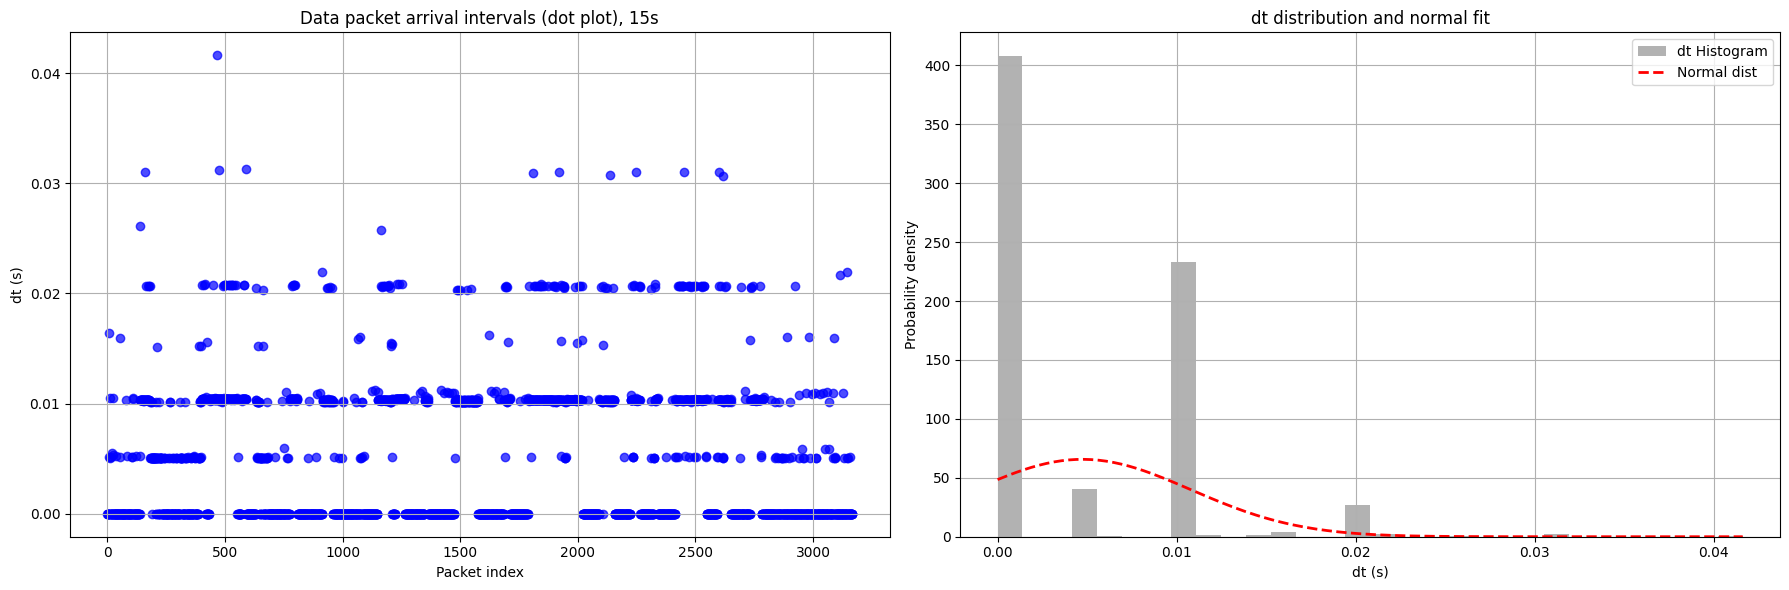

In [ ]:
# 데이터 수신 속도(초당 몇 줄)의 구성을 위한 코드 (점 그래프 및 정규분포 분산 그래프 포함)
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

sample_duration = 15  # 측정할 시간(초)
dt_list = []

# 첫 루프에서 데이터 버리기 (버퍼 청소)
conn.getData()

start_time = time.time()
last_time = start_time

while True:
    loop_data = conn.getData()
    now = time.time()
    if loop_data:
        # 데이터가 있을 때마다 dt 측정
        for _ in loop_data:
            dt = now - last_time
            if len(dt_list) == 0:
                # 첫 데이터라면 dt 0으로
                dt_list.append(0)
            else:
                dt_list.append(dt)
            last_time = now
    if now - start_time >= sample_duration:
        break
    # 쉬는시간 없이, 바로 다음 루프로

print(f"Number of data packets received in {sample_duration} seconds: {len(dt_list)}")
if len(dt_list) > 1:
    print(f"Mean interval: {sum(dt_list[1:])/len(dt_list[1:]):.6f}s, Mean rate: {1/(sum(dt_list[1:])/len(dt_list[1:])):.2f} Hz")

# dt_list visualization (scatter plot + histogram/normal distribution fit)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6))

# 1. Scatter plot: interval (dt) for each data packet
ax1.scatter(range(len(dt_list)), dt_list, color='b', alpha=0.7)
ax1.set_xlabel('Packet index')
ax1.set_ylabel('dt (s)')
ax1.set_title(f'Data packet arrival intervals (dot plot), {sample_duration}s')
ax1.grid(True)

# 2. Histogram and normal distribution curve
dt_arr = np.array(dt_list[1:])  # skip the first dt=0
if len(dt_arr) > 0:
    mu = np.mean(dt_arr)
    sigma = np.std(dt_arr)
    n, bins, patches = ax2.hist(dt_arr, bins=30, density=True, alpha=0.6, color='gray', label='dt Histogram')
    x = np.linspace(dt_arr.min(), dt_arr.max(), 200)
    pdf = norm.pdf(x, mu, sigma)
    ax2.plot(x, pdf, 'r--', linewidth=2, label='Normal dist')
    ax2.set_xlabel('dt (s)')
    ax2.set_ylabel('Probability density')
    ax2.set_title('dt distribution and normal fit')
    ax2.legend()
    ax2.grid(True)
else:
    ax2.text(0.5, 0.5, 'No dt data to plot', ha='center', va='center')

plt.tight_layout()
plt.show()


In [4]:
def printRobotStatusNow(conn,lstate):
    data = conn.getData()
    if data:
        lstate.parseData(data[-1]) # Process the last packet ONLY
        print('+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=')
        print(f'SN [{byte_print(lstate.SN)}]:\t{decode_sn(lstate.SN)}')
        print(f'Ver [{byte_print(lstate.version)}]:\t{decode_version(lstate.version)}')
        print(f'SOC:\t\t\t{lstate.bms.SOC} %')
        print(f'Overall Voltage:\t{getVoltage(lstate.bms.cell_vol)} mv') #something is still wrong here ?!
        print(f'Current:\t\t{lstate.bms.current} mA')
        print(f'Cycles:\t\t\t{lstate.bms.cycle}')
        print(f'Temps BQ:\t\t{lstate.bms.BQ_NTC[0]} °C, {lstate.bms.BQ_NTC[1]}°C')
        print(f'Temps MCU:\t\t{lstate.bms.MCU_NTC[0]} °C, {lstate.bms.MCU_NTC[1]}°C')
        print(f'FootForce:\t\t{lstate.footForce}')
        print(f'FootForceEst:\t\t{lstate.footForceEst}')
        print(f'IMU Temp:\t\t{lstate.imu.temperature}')
        print(f'IMU RPY:\t\tRoll={lstate.imu.rpy[0]:.3f}, Pitch={lstate.imu.rpy[1]:.3f}, Yaw={lstate.imu.rpy[2] :.3f}')
        print(f'MotorState FL_2 MODE:\t\t{lstate.motorState[d["FL_2"]].mode}')
        print('+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=')
    
    # Return the last packet's state
    return lstate

In [ ]:
printRobotStatusNow(conn,lstate)

AttributeError: 'NoneType' object has no attribute 'parseData'

In [8]:
data = conn.getData()
data

[]

In [37]:
while True:
    lstate = printRobotStatusNow(conn,lstate)
    time.sleep(0.01)

AttributeError: 'NoneType' object has no attribute 'parseData'

In [33]:
data = conn.getData()
data

[b'\xfe\xef\xff\x00\x04\x02\x02\x04\x19\x02\r\x00\x00\x01\t\x00\x010\xfa\x7f\xbac\xfd\xfe}?9\xf5\xfd\xbb\xc5\xc5g=\x7fo\xe3=\xd3V\x11<\x12[/<N\xf75:\xec4\x8e\xbf\x00\x16\xfb\xbc>?\x1cA\x8fq9\xbb\x07\xfe\xe9=2\x1dd>O\x00\xee\x11H?p`I;\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00/\x00\x00\x00\x00\x00\x00\x00\x00\x00/\xb5\xf9>y\xa0\xaa\xbb\x01\x00\x06\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00(\x00\x00\x00\x00\x00\x00\x00\x00\x00_\x15-\xc0\xa8\xeb\xbe;\xee\xff\x12\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\'\x00\x00\x00\x00\x01\x00\x00\x00\x00\xddx\r\xbf\xba6\x9b;\x0b\x00\xfa\xff\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00,\x00\x00\x00\x00\x00\x00\x00\x00\x00\x0b\xc3z>\xd5\xdb\xeb:\xed\xff\x06\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00(\x00\x00\x00\x00\x00\x00\x00\x00\x00x\xad.\xc0L\x87\xfe;\xfc\xff\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\'\x00\x00\x00\x00\x01\x00\x00\x00\x00\xb4V_?\xc0#\x85;\xfb\xff\x0c\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00(\x00\x00\x00\x00\x00\x0